In [2]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from diffusion_and_model import Diffusion_without_class,sample,p_losses
from torch import nn, einsum, optim
import torch
import tqdm
import os
# Enable plots inside the Jupyter NotebookLet the
%matplotlib inline
timesteps =1000

In [3]:
model = Diffusion_without_class()

In [4]:
train_image = np.load("cifar10_train_image.npy")
train_label = np.load("cifar10_train_label.npy")
image_1000 = np.array(train_image[:1000])
labels_1000 =np.array(train_label[:1000])


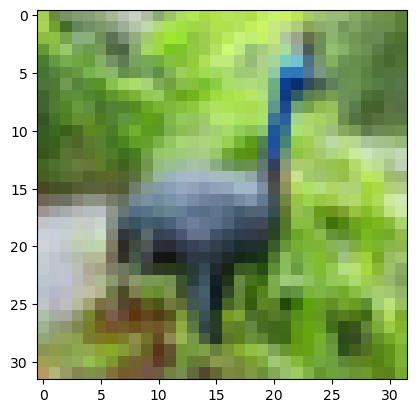

In [9]:
source = torch.tensor(image_1000[6:7].transpose([0,3,1,2]).astype(np.float32)/255)
plt.imshow(source[0].numpy().transpose(1,2,0))

In [10]:
model.load_state_dict(torch.load('cifar10_diffusion_without_class_model_epoch_10000_dataset_1000_sample_1000_time.pth'))

<All keys matched successfully>

torch.Size([1, 3, 32, 32])


sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000
torch.Size([1, 3, 32, 32])


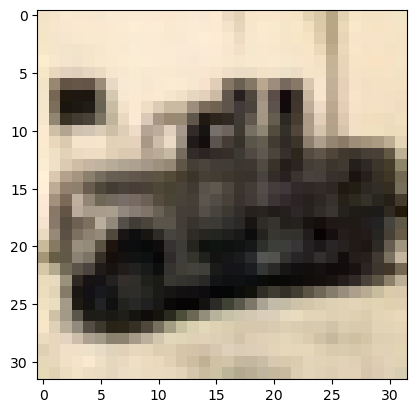

In [11]:
samples = sample(model, image_size=32, batch_size=1, channels=3)

# Get the last sample and normalize it in [0,1]
# last_sample = (samples[-1] - samples[-1].min())/(samples[-1].max()-samples[-1].min())
last_sample = samples[-1]
print(len(samples))
print(last_sample.shape)
plt.imshow((last_sample[0].numpy().transpose(1,2,0)+1.0)/2.0)

In [13]:
from torch import nn, einsum, optim
import torch
import tqdm
class generalized_inverse(nn.Module):
    def __init__(self):
        super().__init__()
        self.color2gray =  torch.tensor([0.299,0.587,0.114], requires_grad=False, dtype=torch.float32).reshape(
            1, 3).to("cuda")
        self.gray2color = torch.tensor([1.0, 1.0,1.0], requires_grad=False, dtype=torch.float32).reshape(
            3, 1).to("cuda")

#         self.w = nn.parameter.Parameter(torch.zeros((2,1000)))
        self.w = nn.parameter.Parameter(torch.zeros((1,3,32,32)))

    def forward(self,Pan):
        #B`Z + (I-B`B)W
        Bg_iZ = einsum('n m, k m w h -> k n w h', self.gray2color, Pan)

        BW = einsum('n m, k m w h -> k n w h', self.color2gray, self.w)
        Bg_iBW  = einsum('n m, k m w h -> k n w h', self.gray2color,  BW )

        W_Bg_iBW = self.w - Bg_iBW

        return Bg_iZ +W_Bg_iBW 

    def A_(self,source):
        Pan = einsum('n m, k m w h -> k n w h', self.color2gray, source)
        return Pan
    def Ay(self,Pan):
        return einsum('n m, k m w h -> k n w h', self.gray2color, Pan)
    
    def get_w(self):
        return self.w

In [16]:

import torch
for index in range(10):
    source = torch.tensor(image_1000[0+index:1+index].transpose([0,3,1,2]).astype(np.float32)/255)

    device = "cuda"
    model=model.to(device)
    g_i =  generalized_inverse()
    g_i = g_i.to("cuda")


    source = source.to("cuda")
    Pan=g_i.A_(source)
    Pan = Pan.to("cuda")
    if not os.path.exists(r"figure\images_colorization_cifar10\origin"):
        os.makedirs(r"figure\images_colorization_cifar10\origin")
    if not os.path.exists(r"figure\images_colorization_cifar10\ours"):
        os.makedirs(r"figure\images_colorization_cifar10\ours")
    file_name = r"figure\images_colorization_cifar10\origin\{0}_origin.png".format(index)
    plt.imsave(file_name,source[0].cpu().numpy().transpose(1,2,0))

    Ay = g_i.Ay(Pan)
    file_name = r"figure\images_colorization_cifar10\origin\{0}_Apy.png".format(index)
    plt.imsave(file_name,Ay[0].cpu().numpy().transpose(1,2,0))
    opt_sgd = optim.SGD(g_i.parameters(), lr=1)

    scaler = torch.cuda.amp.GradScaler()

    #for p in model.parameters():
    #    p.requires_grad = False
    def train_generalized_inverse():
        iteration = 20001

        for i in range(iteration):

            opt_sgd.zero_grad()

            # Evaluate the loss
            #loss = g_i.loss(y)

            signal_x=g_i(Pan)
            t = torch.randint(0, timesteps, (1,), device="cuda").long()

            loss_diffusion = p_losses(model, 2*signal_x-1, t)

            scaler.scale(loss_diffusion).backward()
            scaler.step(opt_sgd)

            scaler.update()
            if i%1000==0:
    #             for p in g_i.parameters():

                print(f' iteration: {i}, loss: {loss_diffusion.item():g}')
    train_generalized_inverse()

    file_name = r"figure\images_colorization_cifar10\ours\{0}_recover.png".format(index)

    signal_x=g_i(Pan)

    plt.imsave(file_name,np.clip(signal_x[0].cpu().detach().numpy().transpose([1,2,0]),0,1))

    file_name = r"figure\images_colorization_cifar10\ours\{0}_w.png".format(index)

    signal_w=g_i.get_w()

    plt.imsave(file_name,np.clip(np.abs(signal_w[0].cpu().detach().numpy().transpose([1,2,0])),0,1))
    
    file_name = r"figure\images_colorization_cifar10\origin\{0}_y.png".format(index)

    plt.imsave(file_name,np.clip(Pan[0,0].cpu().detach().numpy(),0,1),cmap='gray')
    
    rmse = np.sqrt(np.mean((source[0].cpu().numpy().transpose(1,2,0)-signal_x[0].cpu().detach().numpy().transpose([1,2,0]))**2))
    print(f"index {index} rmse {rmse}")
    color2gray=torch.tensor([0.299,0.587,0.114], requires_grad=False, dtype=torch.float32).reshape(
                1, 3).to("cuda")
    consistency = np.sqrt(np.sum((einsum('n m, k m w h -> k n w h',color2gray, signal_x)[0,0].cpu().detach().numpy()-Pan[0,0].cpu().detach().numpy())**2))
    print(f"index {index} consistency {consistency}")

 iteration: 0, loss: 0.0103172
 iteration: 1000, loss: 0.00198074
 iteration: 2000, loss: 0.00136875
 iteration: 3000, loss: 0.00182847
 iteration: 4000, loss: 7.26703e-05
 iteration: 5000, loss: 5.98701e-05
 iteration: 6000, loss: 0.00877699
 iteration: 7000, loss: 0.00256014
 iteration: 8000, loss: 0.00753962
 iteration: 9000, loss: 0.000926029
 iteration: 10000, loss: 0.000276116
 iteration: 11000, loss: 0.000508829
 iteration: 12000, loss: 0.00219461
 iteration: 13000, loss: 0.000302042
 iteration: 14000, loss: 5.17812e-05
 iteration: 15000, loss: 0.000129151
 iteration: 16000, loss: 8.79399e-05
 iteration: 17000, loss: 0.00158345
 iteration: 18000, loss: 0.000569827
 iteration: 19000, loss: 0.0004013
 iteration: 20000, loss: 0.000885755
index 0 rmse 0.009681916795670986
index 0 consistency 5.440201675810385e-07
 iteration: 0, loss: 0.0947122
 iteration: 1000, loss: 0.000105067
 iteration: 2000, loss: 0.000446264
 iteration: 3000, loss: 0.000147664
 iteration: 4000, loss: 0.0006470